# Brain Tumor Classification with Raw Pixel Features

This notebook implements the training and evaluation of SVC and Random Forest models using raw pixel features from brain tumor MRI images. We'll use GridSearchCV to find the best hyperparameters for each model.

## 1. Import Required Libraries

In [5]:
import os
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Set seaborn style
sns.set(style='darkgrid')

# Class label to name mapping
CLASS_NAMES = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary Tumor'
}

## 2. Data Loading and Preprocessing Functions

In [6]:
def load_and_preprocess(data_dir, img_size=64):
    X, y = [], []
    for filename in os.listdir(data_dir):
        if filename.endswith('.mat'):
            file_path = os.path.join(data_dir, filename)
            with h5py.File(file_path, 'r') as f:
                img = np.array(f['cjdata']['image']).T
                label = int(np.array(f['cjdata']['label'])[0][0])
                label -= 1  # zero-based
                img_resized = cv2.resize(img, (img_size, img_size))
                img_norm = img_resized / 255.0
                X.append(img_norm)
                y.append(label)
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images with shape: {X[0].shape}")
    return X, y

def flatten_images(X):
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

## 3. Visualization Functions

In [7]:
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

def show_sample_predictions(X, y_true, y_pred, n_samples=10):
    idxs = np.random.choice(len(X), n_samples, replace=False)
    plt.figure(figsize=(15, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"T: {CLASS_NAMES[y_true[idx]]}\nP: {CLASS_NAMES[y_pred[idx]]}", fontsize=9)
    plt.suptitle('Sample Predictions (T=True, P=Predicted)')
    plt.tight_layout()
    plt.show()

def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, test_mean, 'o-', label='Test Accuracy')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. Load and Preprocess Data

In [8]:
data_dir = 'BrainTumorDataPublic_1-3064'  # Adjust if needed
X, y = load_and_preprocess(data_dir)
X_flat = flatten_images(X)

# Split data
X_train, X_test, y_train, y_test, X_img_train, X_img_test = train_test_split(
    X_flat, y, X, test_size=0.2, random_state=42, stratify=y)

Loaded 3064 images with shape: (64, 64)


## 5. Logestic Regression Model Training and Evaluation

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Classification Report:
{'Meningioma': {'precision': 0.7054263565891473, 'recall': 0.6408450704225352, 'f1-score': 0.6715867158671587, 'support': 142.0}, 'Glioma': {'precision': 0.8372881355932204, 'recall': 0.8666666666666667, 'f1-score': 0.8517241379310345, 'support': 285.0}, 'Pituitary Tumor': {'precision': 0.9629629629629629, 'recall': 0.978494623655914, 'f1-score': 0.9706666666666667, 'support': 186.0}, 'accuracy': 0.8482871125611745, 'macro avg': {'precision': 0.8352258183817769, 'recall': 0.8286687869150388, 'f1-score': 0.8313258401549533, 'support': 613.0}, 'weighted avg': {'precision': 0.8448756482721661, 'recall': 0.8482871125611745, 'f1-score': 0.846085959157392, 'support': 613.0}}


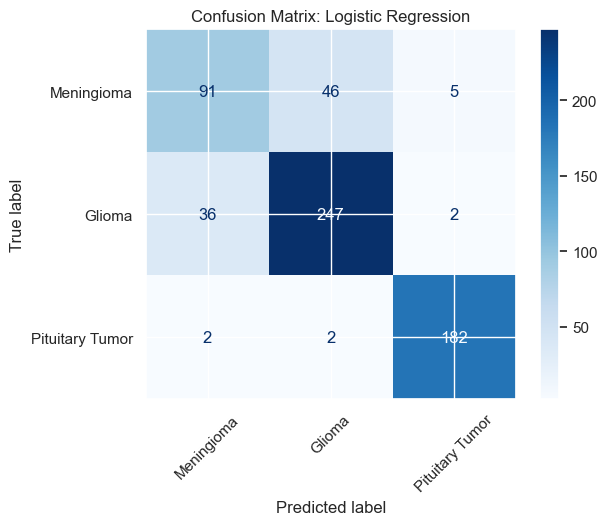

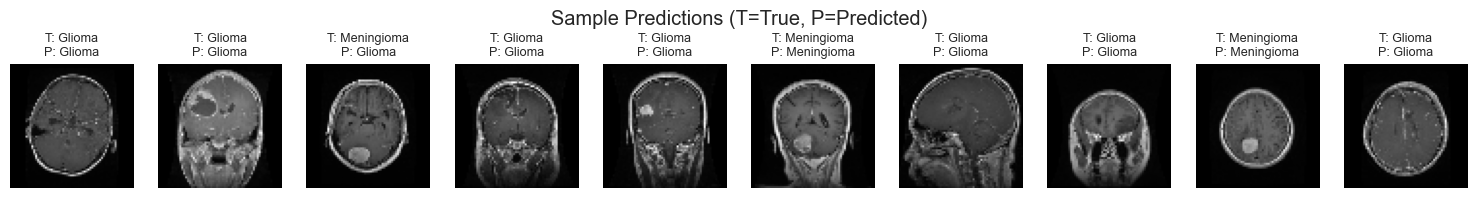

In [15]:

# Train Logistic Regression with optimal parameters
logreg = LogisticRegression(
    C=1,
    max_iter=200, 
    penalty='l2',
    solver='saga',
    random_state=42
)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

# Print results
print('\nLogistic Regression Classification Report:')
logreg_report = classification_report(y_test, y_pred_logreg, target_names=[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))], output_dict=True)
print(logreg_report)

# Visualize results
plot_confusion(y_test, y_pred_logreg, 'Logistic Regression')
show_sample_predictions(X_img_test, y_test, y_pred_logreg)
# plot_learning_curve(logreg, X_train, y_train, 'Logistic Regression')


## 6. SVC Model Training and Evaluation

Performing Grid Search for SVC...
Best SVC parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVC score: 0.90738268423459

SVC Classification Report:
{'Meningioma': {'precision': 0.8181818181818182, 'recall': 0.823943661971831, 'f1-score': 0.8210526315789474, 'support': 142.0}, 'Glioma': {'precision': 0.9151943462897526, 'recall': 0.9087719298245615, 'f1-score': 0.9119718309859155, 'support': 285.0}, 'Pituitary Tumor': {'precision': 0.9893048128342246, 'recall': 0.9946236559139785, 'f1-score': 0.9919571045576407, 'support': 186.0}, 'accuracy': 0.9151712887438825, 'macro avg': {'precision': 0.9075603257685985, 'recall': 0.9091130825701237, 'f1-score': 0.9083271890408344, 'support': 613.0}, 'weighted avg': {'precision': 0.9152086493663351, 'recall': 0.9151712887438825, 'f1-score': 0.9151802071173207, 'support': 613.0}}


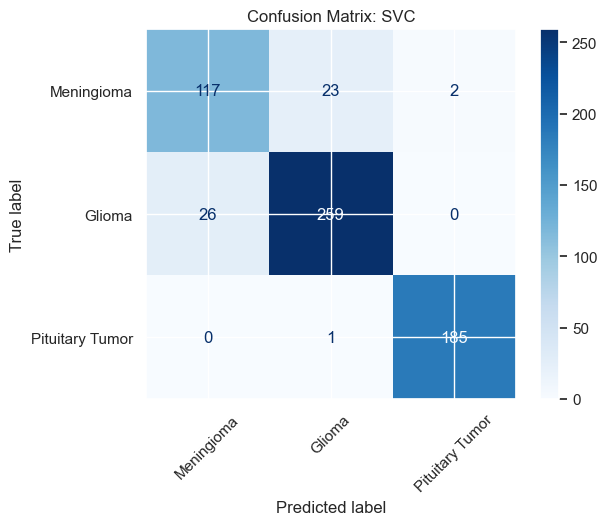

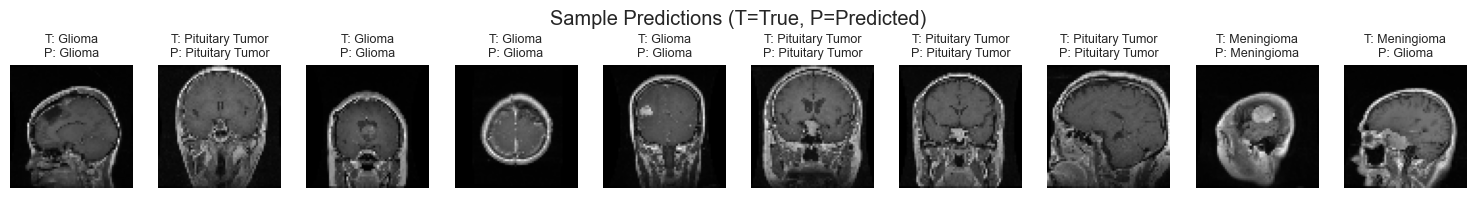

In [ ]:

# Train SVC with optimal parameters
svc = SVC(
    C=10,
    gamma='scale',
    kernel='rbf',
    probability=True,
    random_state=42
)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

# Print results
print('\nSVC Classification Report:')
svc_report = classification_report(y_test, y_pred_svc, target_names=[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))],  output_dict=True)
print(svc_report)

# Visualize results
plot_confusion(y_test, y_pred_svc, 'SVC')
show_sample_predictions(X_img_test, y_test, y_pred_svc)
# plot_learning_curve(svc, X_train, y_train, 'SVC')

## 7. Decison Tree Model Training and Evaluation

Performing Grid Search for Decision Tree...
Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree score: 0.864138160355792

Decision Tree Classification Report:
{'Meningioma': {'precision': 0.6688741721854304, 'recall': 0.7112676056338029, 'f1-score': 0.689419795221843, 'support': 142.0}, 'Glioma': {'precision': 0.8647686832740213, 'recall': 0.8526315789473684, 'f1-score': 0.8586572438162544, 'support': 285.0}, 'Pituitary Tumor': {'precision': 0.9171270718232044, 'recall': 0.8924731182795699, 'f1-score': 0.9046321525885559, 'support': 186.0}, 'accuracy': 0.831973898858075, 'macro avg': {'precision': 0.8169233090942187, 'recall': 0.8187907676202472, 'f1-score': 0.8175697305422177, 'support': 613.0}, 'weighted avg': {'precision': 0.8352770677692387, 'recall': 0.831973898858075, 'f1-score': 0.8334037614854904, 'support': 613.0}}


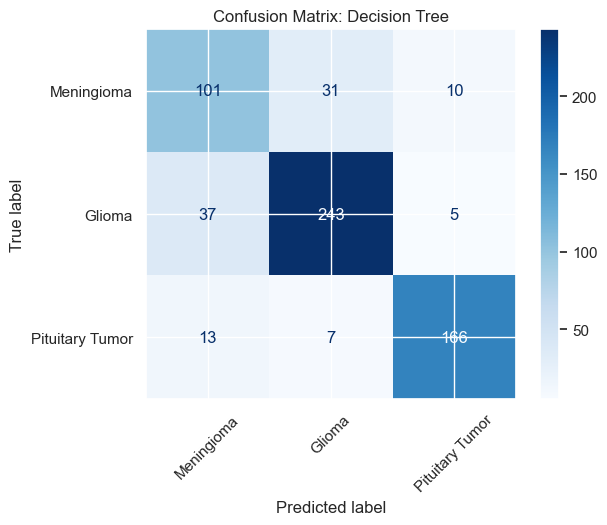

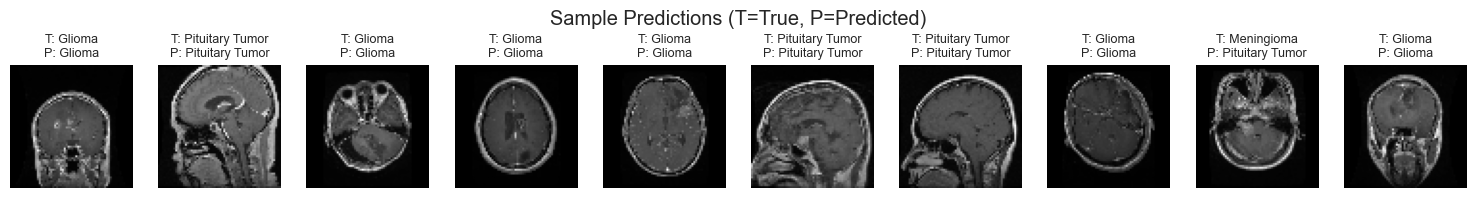

In [11]:

# Create Decision Tree with best parameters from previous grid search
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5, 
    min_samples_leaf=2,
    criterion='entropy',
    random_state=42
)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

# Print results
print('\nDecision Tree Classification Report:')
dt_report = classification_report(y_test, y_pred_dt, target_names=[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))], output_dict=True)
print(dt_report)

# Visualize results
plot_confusion(y_test, y_pred_dt, 'Decision Tree')
show_sample_predictions(X_img_test, y_test, y_pred_dt)
# plot_learning_curve(dt, X_train, y_train, 'Decision Tree')


## 8. Random Forest Model Training and Evaluation


Random Forest Classification Report:
{'Meningioma': {'precision': 0.8024691358024691, 'recall': 0.9154929577464789, 'f1-score': 0.8552631578947368, 'support': 142.0}, 'Glioma': {'precision': 0.98046875, 'recall': 0.8807017543859649, 'f1-score': 0.9279112754158965, 'support': 285.0}, 'Pituitary Tumor': {'precision': 0.9487179487179487, 'recall': 0.9946236559139785, 'f1-score': 0.9711286089238845, 'support': 186.0}, 'accuracy': 0.9233278955954323, 'macro avg': {'precision': 0.9105519448401393, 'recall': 0.9302727893488075, 'f1-score': 0.9181010140781726, 'support': 613.0}, 'weighted avg': {'precision': 0.9296015489322824, 'recall': 0.9233278955954323, 'f1-score': 0.9241957637429457, 'support': 613.0}}


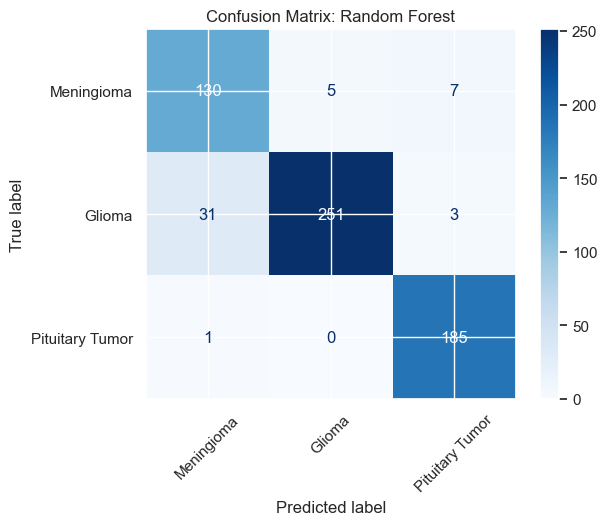

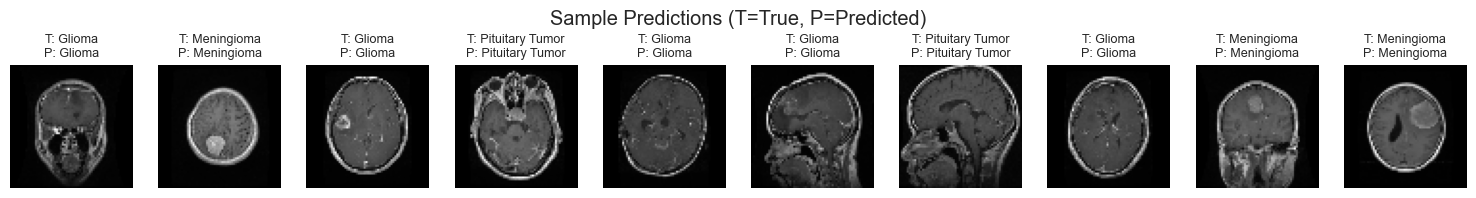

In [14]:

# Create Random Forest with best parameters from previous grid search
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)

# Print results
print('\nRandom Forest Classification Report:')
rf_report = classification_report(y_test, y_pred_rf, target_names=[CLASS_NAMES[i] for i in range(len(CLASS_NAMES))], output_dict=True)
print(rf_report)

# Visualize results
plot_confusion(y_test, y_pred_rf, 'Random Forest')
show_sample_predictions(X_img_test, y_test, y_pred_rf)
# plot_learning_curve(rf, X_train, y_train, 'Random Forest')

## 7. Save Models

In [13]:
# Save models
joblib.dump(logreg, "models/logreg_model.pkl")
joblib.dump(svc, "models/svc_model.pkl")
joblib.dump(dt,  "models/dt_model.pkl")
joblib.dump(rf,  "models/rf_model.pkl")

# Save metrics
joblib.dump(logreg_report, "models/svc_metrics.pkl")
joblib.dump(svc_report,  "models/rf_metrics.pkl")
joblib.dump(dt_report, "models/svc_metrics.pkl")
joblib.dump(rf_report,  "models/rf_metrics.pkl")
print("Models and classification-report metrics saved.")

Models and classification-report metrics saved.
